# 対話の学習
宮沢賢治の小説において、次の文章を予測できるようにSeq2Seqのモデルを訓練します。  
これにより、賢治風の返答が生成できるようになります。

## 使用する文字
学習をなるべく簡単にするために、ひらがなとカタカナ、記号のみを使用します。  
コーパスで使われていない文字の入力にも対応するために、全てのひらがなとカタカナを用意します。  
また、それ以外の記号などについては、コーパスで使われているものを加えます。

In [1]:
import pickle

hiragana = "ぁあぃいぅうぇえぉおかがきぎくぐけげこごさざしじすずせぜそぞ\
ただちぢっつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽ\
まみむめもゃやゅゆょよらりるれろゎわゐゑをん"

katakana = "ァアィイゥウェエォオカガキギクグケゲコゴサザシジスズセゼソゾ\
タダチヂッツヅテデトドナニヌネノハバパヒビピフブプヘベペホボポ\
マミムメモャヤュユョヨラリルレロヮワヰヱヲンヴ"

chars = hiragana + katakana

with open("kana_kenji.txt", mode="r", encoding="utf-8") as f:  # 前回保存したファイル
    text = f.read()
    
for char in text:  # ひらがな、カタカナ以外でコーパスに使われている文字を追加
    if char not in chars:
        chars += char
        
chars += "\t\n"  # タブと改行を追加
        
chars_list = sorted(list(chars))  # 文字列をリストに変換してソートする
print(chars_list)

with open("kana_chars.pickle", mode="wb") as f:  # pickleで保存
    pickle.dump(chars_list, f)

['\t', '\n', '、', '。', '々', 'ぁ', 'あ', 'ぃ', 'い', 'ぅ', 'う', 'ぇ', 'え', 'ぉ', 'お', 'か', 'が', 'き', 'ぎ', 'く', 'ぐ', 'け', 'げ', 'こ', 'ご', 'さ', 'ざ', 'し', 'じ', 'す', 'ず', 'せ', 'ぜ', 'そ', 'ぞ', 'た', 'だ', 'ち', 'ぢ', 'っ', 'つ', 'づ', 'て', 'で', 'と', 'ど', 'な', 'に', 'ぬ', 'ね', 'の', 'は', 'ば', 'ぱ', 'ひ', 'び', 'ぴ', 'ふ', 'ぶ', 'ぷ', 'へ', 'べ', 'ぺ', 'ほ', 'ぼ', 'ぽ', 'ま', 'み', 'む', 'め', 'も', 'ゃ', 'や', 'ゅ', 'ゆ', 'ょ', 'よ', 'ら', 'り', 'る', 'れ', 'ろ', 'ゎ', 'わ', 'ゐ', 'ゑ', 'を', 'ん', 'ァ', 'ア', 'ィ', 'イ', 'ゥ', 'ウ', 'ェ', 'エ', 'ォ', 'オ', 'カ', 'ガ', 'キ', 'ギ', 'ク', 'グ', 'ケ', 'ゲ', 'コ', 'ゴ', 'サ', 'ザ', 'シ', 'ジ', 'ス', 'ズ', 'セ', 'ゼ', 'ソ', 'ゾ', 'タ', 'ダ', 'チ', 'ヂ', 'ッ', 'ツ', 'ヅ', 'テ', 'デ', 'ト', 'ド', 'ナ', 'ニ', 'ヌ', 'ネ', 'ノ', 'ハ', 'バ', 'パ', 'ヒ', 'ビ', 'ピ', 'フ', 'ブ', 'プ', 'ヘ', 'ベ', 'ペ', 'ホ', 'ボ', 'ポ', 'マ', 'ミ', 'ム', 'メ', 'モ', 'ャ', 'ヤ', 'ュ', 'ユ', 'ョ', 'ヨ', 'ラ', 'リ', 'ル', 'レ', 'ロ', 'ヮ', 'ワ', 'ヰ', 'ヱ', 'ヲ', 'ン', 'ヴ', '・', 'ー', '？']


## 文字のベクトル化
各文字をone-hot表現で表し、encoderへの入力、decoderへの入力、decoderの正解を作成します。  
各文章はそれぞれ長さが違いますが、文章の終了後は全て0のベクトルで埋めます。  
学習効率を考慮し、長すぎる文章はカットします。

In [2]:
import numpy as np

# インデックスと文字で辞書を作成
char_indices = {}  # 文字がキーでインデックスが値
for i, char in enumerate(chars_list):
    char_indices[char] = i
indices_char = {}  # インデックスがキーで文字が値
for i, char in enumerate(chars_list):
    indices_char[i] = char
    
seperator = "。"
sentence_list = text.split(seperator) 
sentence_list.pop() 
sentence_list = [x+seperator for x in sentence_list]

max_sentence_length = 128  # 文章の最大長さ。これより長い文章はカットされる。
sentence_list = [sentence for sentence in sentence_list if len(sentence) <= max_sentence_length]  # 長すぎる文章のカット

n_char = len(chars_list)  # 文字の種類の数
n_sample = len(sentence_list) - 1  # サンプル数

x_sentences = []  # 入力の文章
t_sentences = []  # 正解の文章
for i in range(n_sample):
    x_sentences.append(sentence_list[i])
    t_sentences.append("\t" + sentence_list[i+1] + "\n")  # 正解は先頭にタブ、末尾に改行を加える
max_length_x = max_sentence_length  # 入力文章の最大長さ
max_length_t = max_sentence_length + 2  # 正解文章の最大長さ

x_encoder = np.zeros((n_sample, max_length_x, n_char), dtype=np.bool)  # encoderへの入力
x_decoder = np.zeros((n_sample, max_length_t, n_char), dtype=np.bool)  # decoderへの入力
t_decoder = np.zeros((n_sample, max_length_t, n_char), dtype=np.bool)  # decoderの正解

for i in range(n_sample):
    x_sentence = x_sentences[i]
    t_sentence = t_sentences[i]
    for j, char in enumerate(x_sentence):
        x_encoder[i, j, char_indices[char]] = 1  # encoderへの入力をone-hot表現で表す
    for j, char in enumerate(t_sentence):
        x_decoder[i, j, char_indices[char]] = 1  # decoderへの入力をone-hot表現で表す
        if j > 0:  # 正解は入力より1つ前の時刻のものにする
            t_decoder[i, j-1, char_indices[char]] = 1
            
print(x_encoder.shape)

(5091, 128, 175)


## 各設定
学習に関する各設定です。  
「早期終了」により学習を自動ストップするので、エポック数は多めに設定します。

In [3]:
batch_size = 32
epochs = 1000
n_mid = 256  # 中間層のニューロン数

## 学習用モデルの構築
学習用のSeq2Seqモデルを構築します。  
今回は、前のセクションでより自然な文章の作成につながったGRUを使います。  
また、入力の直後にMasking層を挟みます。
これにより、全ての要素が0であるベクトルの入力は無視されます。  

GRU層にはdropoutを設定し、ニューロンをランダムに無効にすることで過学習対策をします。  
過学習とは、モデルが訓練データに過剰に適応してしまい、未知のデータに対して機能しなくなってしまうことです。

In [4]:
from keras.models import Model
from keras.layers import Dense, GRU, Input, Masking

encoder_input = Input(shape=(None, n_char))
encoder_mask = Masking(mask_value=0)  # 全ての要素が0であるベクトルの入力は無視する
encoder_masked = encoder_mask(encoder_input)
encoder_lstm = GRU(n_mid, dropout=0.2, recurrent_dropout=0.2, return_state=True)  # dropoutを設定し、ニューロンをランダムに無効にする
encoder_output, encoder_state_h = encoder_lstm(encoder_masked)

decoder_input = Input(shape=(None, n_char))
decoder_mask = Masking(mask_value=0)  # 全ての要素が0であるベクトルの入力は無視する
decoder_masked = decoder_mask(decoder_input)
decoder_lstm = GRU(n_mid, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=True)  # dropoutを設定
decoder_output, _ = decoder_lstm(decoder_masked, initial_state=encoder_state_h)  # encoderの状態を初期状態にする
decoder_dense = Dense(n_char, activation='softmax')
decoder_output = decoder_dense(decoder_output)

model = Model([encoder_input, decoder_input], decoder_output)

model.compile(loss="categorical_crossentropy", optimizer="rmsprop")
print(model.summary())

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 175)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 175)    0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, None, 175)    0           input_1[0][0]                    
__________________________________________________________________________________________________
masking_2 (Masking)             (None, None, 175)    0           input_2[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU

## 学習
構築したSeq2Seqのモデルを使って、学習を行います。  
今回は、**早期終了**を設定します。  
コールバックにEarlyStoppingを設定することで、学習を自動で終了させることができます。  
誤差に改善が見られなくなってからpatianceで設定したエポック数が経過すると、学習は終了となります。  
お手元の環境にもよりますが学習には数時間程度必要ですので、早く結果を確認したい方はpatienceの値を小さくしましょう。  

In [5]:
from keras.callbacks import EarlyStopping 

# val_lossに改善が見られなくなってから、30エポックで学習は終了
early_stopping = EarlyStopping(monitor="val_loss", patience=30) 

history = model.fit([x_encoder, x_decoder], t_decoder,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.1,  # 10%は検証用
                     callbacks=[early_stopping])

Train on 4581 samples, validate on 510 samples
Epoch 1/1000
4581/4581 [==============================] - 138s 30ms/step - loss: 3.7477 - val_loss: 3.4353
Epoch 2/1000
4581/4581 [==============================] - 138s 30ms/step - loss: 3.3154 - val_loss: 3.2225
Epoch 3/1000
4581/4581 [==============================] - 142s 31ms/step - loss: 3.1636 - val_loss: 3.1211
Epoch 4/1000
4581/4581 [==============================] - 145s 32ms/step - loss: 3.0768 - val_loss: 3.0734
Epoch 5/1000
4581/4581 [==============================] - 141s 31ms/step - loss: 3.0233 - val_loss: 3.0197
Epoch 6/1000
4581/4581 [==============================] - 142s 31ms/step - loss: 2.9817 - val_loss: 2.9727
Epoch 7/1000
4581/4581 [==============================] - 137s 30ms/step - loss: 2.9453 - val_loss: 2.9475
Epoch 8/1000
4581/4581 [==============================] - 135s 30ms/step - loss: 2.9179 - val_loss: 2.9204
Epoch 9/1000
4581/4581 [==============================] - 135s 29ms/step - loss: 2.8843 - val_los

## 学習の推移
誤差の推移を確認します。

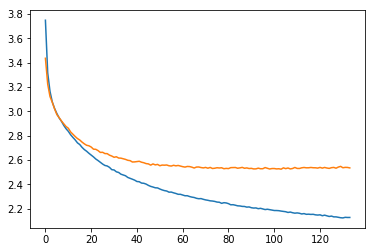

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(loss)), loss)
plt.plot(np.arange(len(val_loss)), val_loss)
plt.show()

検証用データの誤差は途中で改善が止まっていますね。  
もう少し早めに学習を終了しても良さそうです。  
誤差の値自体はあまり小さくなっていませんが、とりあえず対話文の生成を試してみましょう。

## 予測用モデルの構築
学習済みのオブジェクトから、encoder、decoderのモデルを個別に構築します。    
encoderは入力を受け取って状態を返し、decoderは入力と状態を受け取って出力と状態を返すようにします。  
構築したモデルは、後のレクチャーで使えるように保存しておきます。  

In [7]:
# encoderのモデル
encoder_model = Model(encoder_input, encoder_state_h)

# decoderのモデル
decoder_state_in_h = Input(shape=(n_mid,))
decoder_state_in = [decoder_state_in_h]

decoder_output, decoder_state_h = decoder_lstm(decoder_input,
                                               initial_state=decoder_state_in_h)
decoder_output = decoder_dense(decoder_output)

decoder_model = Model([decoder_input] + decoder_state_in,
                      [decoder_output, decoder_state_h])

# モデルの保存
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

/anaconda3/envs/nlp_bot/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer gru_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


## 返答作成用の関数
入力を出力に変換し、返答を作成するための関数を設定します。  
decoderでは、各時刻ごとに予測を行い、出力と状態を次の時刻に渡します。  
decoderの出力を確率として捉え、その確率に従ってサンプリングを行うので実行するたびにやや異なる文章が生成されます。

In [47]:
def respond(input_data, beta=5):
    state_value = encoder_model.predict(input_data)
    y_decoder = np.zeros((1, 1, n_char))  # decoderの出力を格納する配列
    y_decoder[0][0][char_indices["\t"]] = 1  # decoderの最初の入力はタブ。one-hot表現にする。

    respond_sentence = ""  # 返答の文字列
    while True:
        y, h = decoder_model.predict([y_decoder, state_value])
        p_power = y[0][0] ** beta  # 確率分布の調整
        next_index = np.random.choice(len(p_power), p=p_power/np.sum(p_power)) 
        next_char = indices_char[next_index]  # 次の文字

        if (next_char == "\n" or len(respond_sentence) >= max_length_x):
            break  # 次の文字が改行のとき、もしくは最大文字数を超えたときは終了
            
        respond_sentence += next_char
        y_decoder = np.zeros((1, 1, n_char))  # 次の時刻の入力
        y_decoder[0][0][next_index] = 1

        state_value = h  # 次の時刻の状態

    return respond_sentence

## 動作の確認
訓練データの最初の100文を使って、どのような返答が返ってくるかを確かめます。

In [72]:
for i in range(100):  
    x_in = x_encoder[i:i+1]  # 入力
    responce = respond(x_in)  # 返答
    print("Input:", x_sentences[i])
    print("Response:", responce)
    print()

Input: ではみなさんは、そういうふうにかわだといわれたり、ちちのながれたあとだといわれたりしていたこのぼんやりとしろいものがほんとうはなにかごしょうちですか。
Response: せんせいはまたいっっていました。

Input: せんせいは、こくばんにつるしたおおきなくろいせいざのずの、うえからしたへしろくけぶったぎんがおびのようなところをさしながら、みんなにとをかけました。
Response: おとうさんがもうしました。

Input: カムパネルラがてをあげました。
Response: そしてそのまえにはいっているのでした。

Input: それからしごにんてをあげました。
Response: それから、そのとき、あかいはかせは、あおいひかりをつかまえていましたが、そのときは、あかいはかせは、あかいはしらないというように、そのときあたまをかけて、いっしょうけんいのちになっていました。

Input: ジョバンニもてをあげようとして、いそいでそのままやめました。
Response: そしてそのおとこは、きっとみんなはなにかかおをあけて、いっしょに、いっしょに、いっしょうけんいのち、あかいひかりをして、それから、そのときあたまをかけて、それから、きっとまっていました。

Input: たしかにあれがみんなほしだと、いつかざっしでよんだのでしたが、このごろはジョバンニはまるでまいにちきょうしつでもねむく、ほんをよむひまもよむほんもないので、なんだかどんなこともよくわからないというきもちがするのでした。
Response: ところがそのこどもは、そのとき、あかいはいってきたのです。

Input: ところがせんせいははやくもそれをみつけけたのでした。
Response: そしてそのまえにはしっていました。

Input: ジョバンニさん。
Response: あなたはこんどはおおきなこえでした。

Input: あなたはわかっているのでしょう。
Response: ジョバンニは、なにかおもいました。

Input: ジョバンニはせいよくたちあがりましたが、たってみるともうはっきりとそれをこたえることができないのでした。
Response: そしてそのときは、あおいひかりをして、そのときあたまをあけて、いっしょうけんいのち、あかいのはらのほうへはいっていました。



Input: ぼくおとうさんはきっとかんもなくかえってくるとおもうよ。
Response: ああこのときは、あのときは、あのときは、あたまをあけて、いちろうがたずねました。

Input: あああたしもそうおもう。
Response: またさぶろうはすっかりおとこはあたまをあけて、それからもうしました。

Input: けれどもおまえはどうしてそうおもうの。
Response: だいじょうぶですよ。

Input: だってけさのしんぶんにこんねんはきたのほうのりょうはだいへんよかったとかいてあったよ。
Response: それから？それから？それから？それから？それから？それから？それから？それから？それから？それから？それから？それから？それから？それから？それから？それから？それから？それから？それから？それから？それから？それから？それから？それから？それから？それか

Input: ああだけどねえ、おとうさんはりょうへでていないかもしれない。
Response: こういちはまだあおいひかりをして、それからあたまをあけて、いっしょうけんいのち、あおいひかりをして、そのときあしをたてていきました。

Input: きっとでているよ。
Response: そうだ。

Input: おとうさんがかんごくへいるようなそんなわるいことをしたはずがないんだ。
Response: このときは、あかいはたいへんあるいているんだ。



小説内の文章に対して、しばしばそれらしい返答ができていますね。  
中には、意味がよく分からない返答もあります。

次のレクチャーでは、小説外の文章に対してモデルがどのように返答するのか検証していきます。

## 課題
上記のセルでbetaの値を変更し、返答の文章がどのように変化するか確かめてみましょう。